<a href="https://colab.research.google.com/github/nougat11/HUB/blob/master/Copy_of_overfitting_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overfitting and Regularization

## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [ ]:
!pip install --upgrade scikit-learn
set_config(display='diagram')

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.1)


## Settings

In [ ]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [ ]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

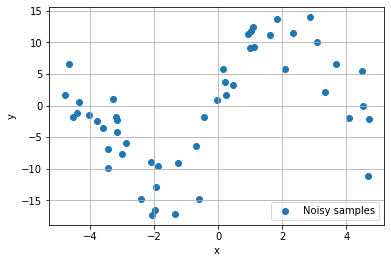

In [ ]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

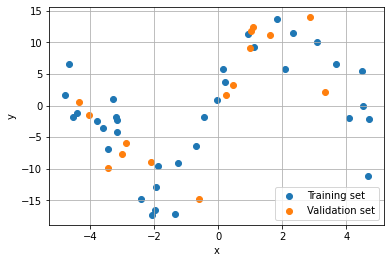

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [ ]:
PolynomialFeatures(degree=4).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [ ]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg', LinearRegression(fit_intercept=False))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Lasso(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Ridge(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

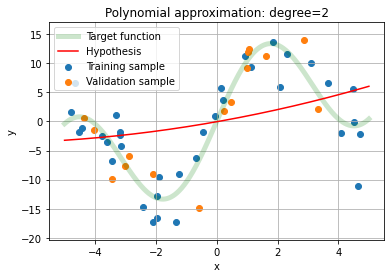

In [ ]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

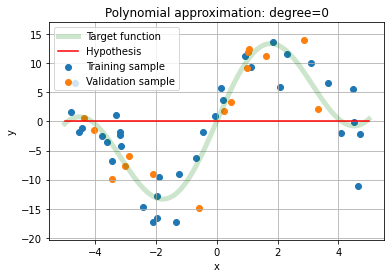

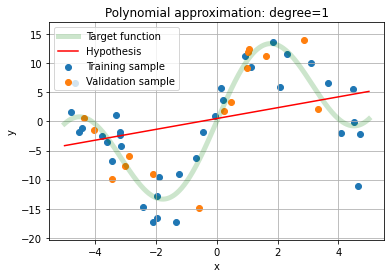

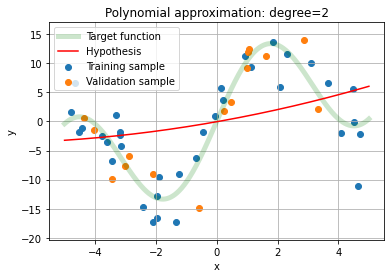

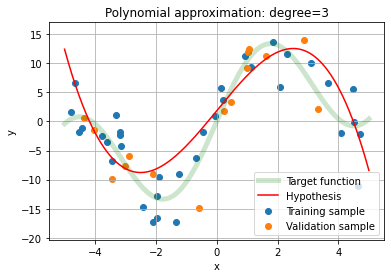

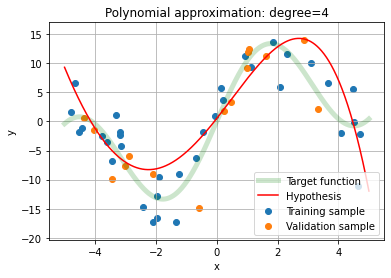

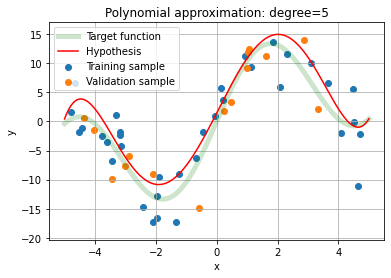

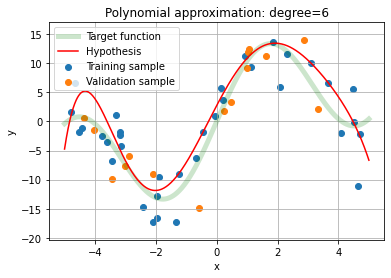

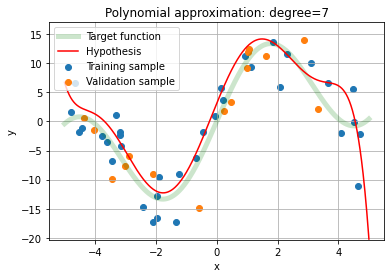

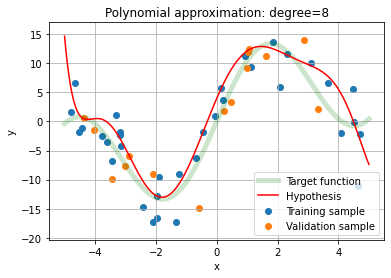

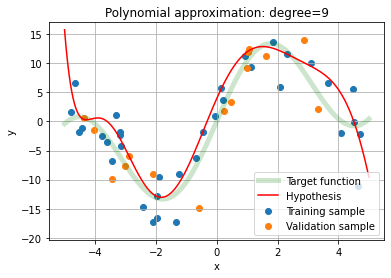

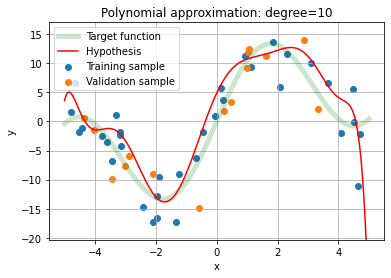

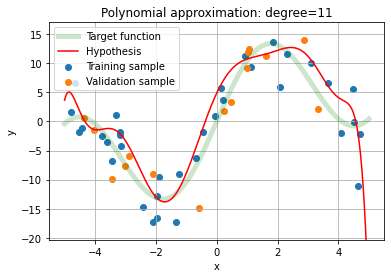

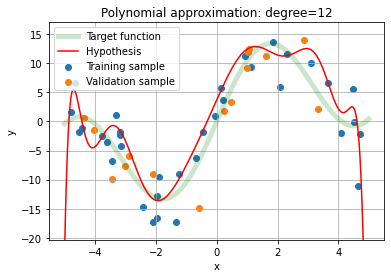

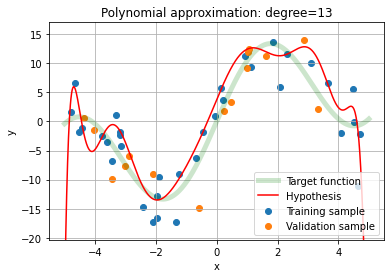

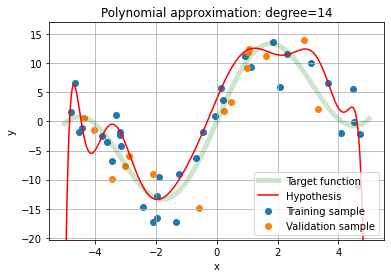

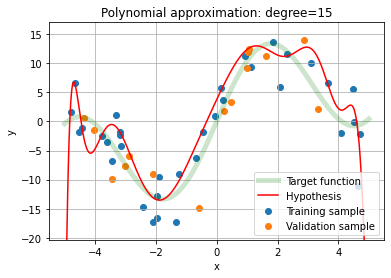

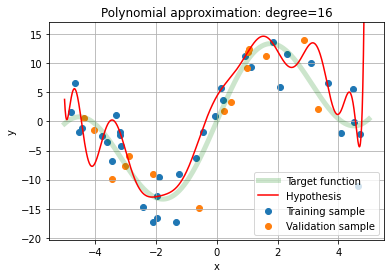

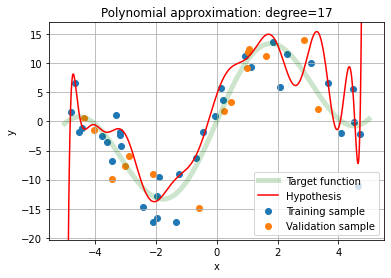

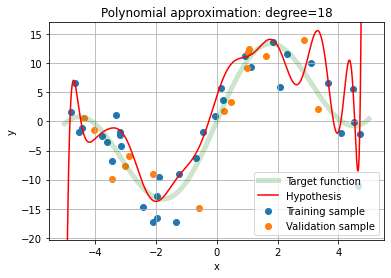

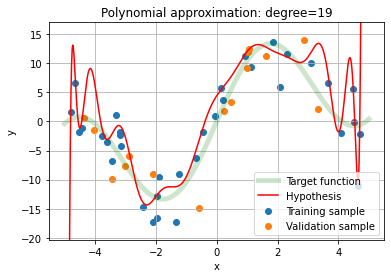

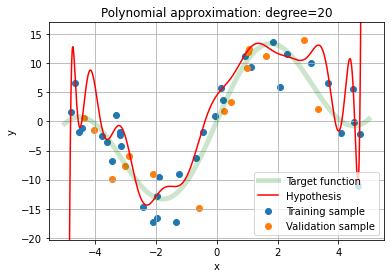

In [ ]:
for degree in range(0,21):
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

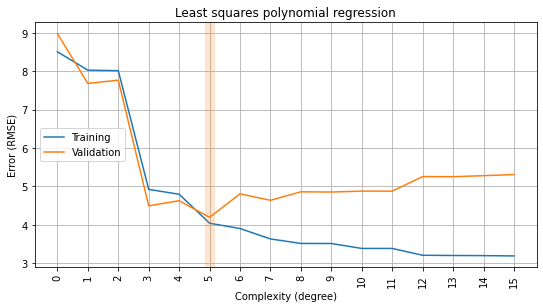

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [ ]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

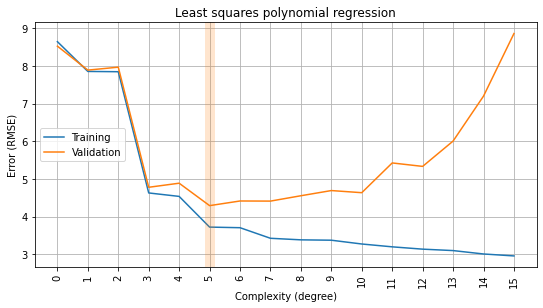

In [ ]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [ ]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.        , 2.81292778]),
 array([0.        , 2.80049884, 0.45166501]),
 array([  0.        ,  30.87315584,   1.48752361, -54.60227825,
         -1.63699842,  26.62792933]),
 array([   0.        ,   33.63850705,  -41.86346242,  -70.48743112,
         278.98853452,   27.48125634, -656.36383501,   59.32988346,
         651.64795186,  -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

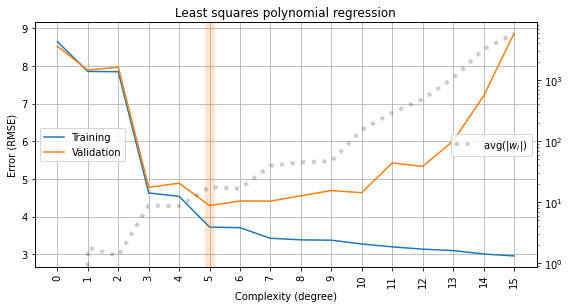

In [ ]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

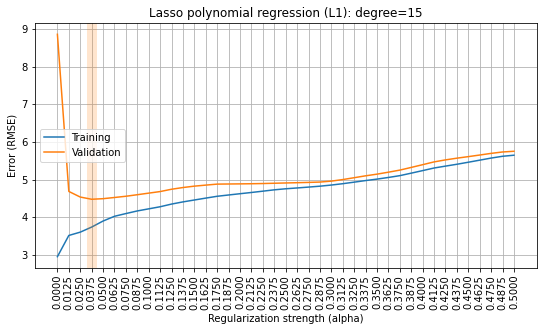

In [ ]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

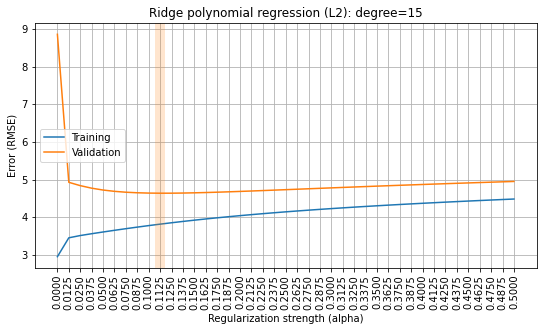

In [ ]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

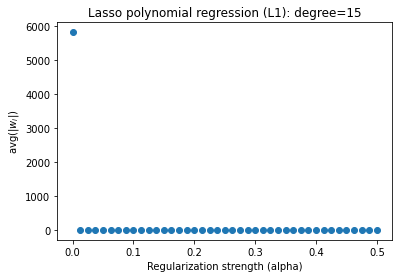

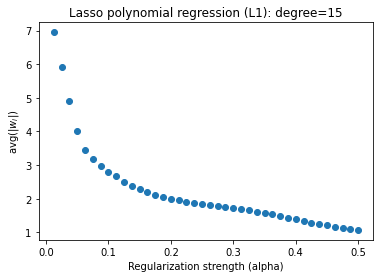

[0.0, 40.993315913048754, 15.763378889780919, 201.2979188109959, 331.1026122381582, 1022.7909272747507, 2597.485587334235, 4590.509122630678, 8289.899531699066, 12903.478374316317, 12779.205699930555, 19190.28067320314, 9712.184667191123, 14256.776997252397, 2857.212664915799, 4159.616668008841]
[0.0, 28.840109375610343, 0.524562991216917, 43.53854923971484, 0.6287467013223518, 0.0, 0.4096354546410007, 25.106772744143193, 0.0, 1.990992561752454, 0.0, 0.0, 0.0, 0.0, 1.0626644486286334, 9.105437104202801]
[0.0, 21.498758627937626, 0.5845353153587911, 23.267755650467574, 0.0, 0.0, 0.0, 1.2258099412833983, 0.24952436792794747, 3.561968284992235, 0.13911448034891238, 0.0, 0.14273958910397128, 0.0, 0.2761158285449006, 0.0]
[0.0, 18.37070778308472, 0.3872785449676691, 17.214521734131452, 0.0, 0.0, 0.0, 0.0, 0.006939387794739906, 0.0, 0.09394343031991051, 0.8892928700734808, 0.08610208082253142, 0.5641278710454829, 0.464399143899836, 0.02953723943991989]
[0.0, 16.574740767687633, 0.20851697177

In [ ]:
avg_coef = []
for alpha in ALPHAS:
  results = cross_validate(make_model(degree = 15, penalty = 'L1', alpha=alpha),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
  avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
plt.scatter(ALPHAS, avg_coef)
plt.title('Lasso polynomial regression (L1): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('avg(|$w_i$|)')
plt.show()
avg_coef = []
for alpha in ALPHAS[1:]:
  results = cross_validate(make_model(degree = 15, penalty = 'L1', alpha=alpha),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
  avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
plt.scatter(ALPHAS[1:], avg_coef)
plt.title('Lasso polynomial regression (L1): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('avg(|$w_i$|)')
plt.show()
avg_coef_matrix, avg_coef = [], []
for alpha in ALPHAS:
  results = cross_validate(make_model(degree = 15, penalty = 'L1', alpha=alpha),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
  avg_coef_matrix.append(        
        # average over CV folds
        np.array([            
            # mean absolute value of weights
            np.array(np.abs(model['reg'].coef_))
            
            for model in results['estimator']
        ]))
for matrix in avg_coef_matrix:
  avg_coef.append(
      [
                np.mean(matrix[:, i])
                for i in range(len(matrix[0]))
      ]
  )
#print(avg_coef_matrix)
print(avg_coef[0])
print(*avg_coef[1::5], sep = '\n')
print(avg_coef[-1])
  


#### L2

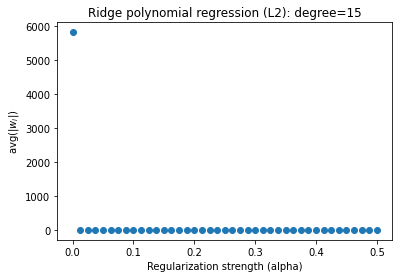

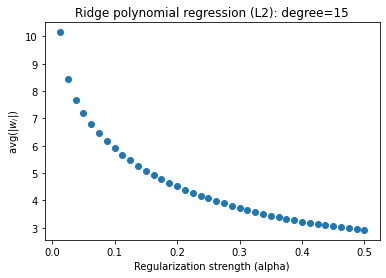

[0.0, 40.993315913048754, 15.763378889780919, 201.2979188109959, 331.1026122381582, 1022.7909272747507, 2597.485587334235, 4590.509122630678, 8289.899531699066, 12903.478374316317, 12779.205699930555, 19190.28067320314, 9712.184667191123, 14256.776997252397, 2857.212664915799, 4159.616668008841]
[0.0, 29.41825728137018, 2.8007390201004605, 46.46791419959893, 7.588316051395978, 6.309675632953898, 7.575866580468945, 16.230450295214162, 3.4538680997960114, 10.053669981480688, 4.605817804855109, 4.376030546948412, 4.625362542790682, 5.100474206591047, 5.446735258555993, 8.382300334790177]
[0.0, 24.707427098312507, 1.378645950176395, 30.128081239364263, 3.5528295001800863, 4.368590764936983, 1.5285244306762755, 8.16603356391846, 2.125212174223942, 9.407297188790324, 1.2098063067768097, 5.117445779956692, 0.6966866672298553, 1.3603564218499922, 1.2366861512207958, 8.381567716069226]
[0.0, 22.44175600928847, 0.9694909614589253, 24.03797838899675, 2.7643607950737703, 5.595680637239924, 1.06637

In [ ]:
avg_coef = []
for alpha in ALPHAS:
  results = cross_validate(make_model(degree = 15, penalty = 'L2', alpha=alpha),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
  avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
plt.scatter(ALPHAS, avg_coef)
plt.title('Ridge polynomial regression (L2): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('avg(|$w_i$|)')
plt.show()
avg_coef = []
for alpha in ALPHAS[1:]:
  results = cross_validate(make_model(degree = 15, penalty = 'L2', alpha=alpha),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
  avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            
            for model in results['estimator']
        ]))
plt.scatter(ALPHAS[1:], avg_coef)
plt.title('Ridge polynomial regression (L2): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('avg(|$w_i$|)')
plt.show()
avg_coef_matrix, avg_coef = [], []
for alpha in ALPHAS:
  results = cross_validate(make_model(degree = 15, penalty = 'L2', alpha=alpha),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
  avg_coef_matrix.append(        
        # average over CV folds
        np.array([            
            # mean absolute value of weights
            np.array(np.abs(model['reg'].coef_))
            
            for model in results['estimator']
        ]))
for matrix in avg_coef_matrix:
  avg_coef.append(
      [
                np.mean(matrix[:, i])
                for i in range(len(matrix[0]))
      ]
  )
#print(avg_coef_matrix)
print(avg_coef[0])
print(*avg_coef[1::5], sep = '\n')
print(avg_coef[-1])
  


#### Summary

Для начала обобщим момент, почему нарисовано 2 графика. Думаю ответить на этот вопрос можно и без объяснения, потому что коэффициент λ = 0, отключает штрафную функцию и регуляризация фактически не происходит.
Давайте же разберемся, что здесь произошло
##### Lasso 
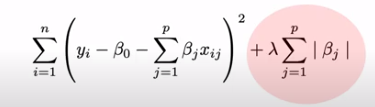

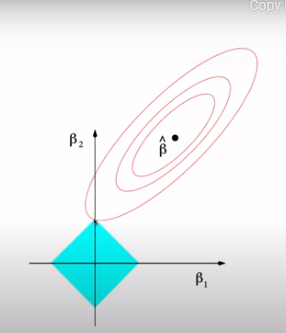

The lasso performs  shrinkage so that there are "corners'' in the constraint, which in two dimensions corresponds to a diamond. If the sum of squares "hits'' one of these corners, then the coefficient corresponding to the axis is shrunk to zero.

Therefore, some components are equal to zero

##### Ridge

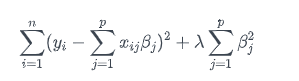

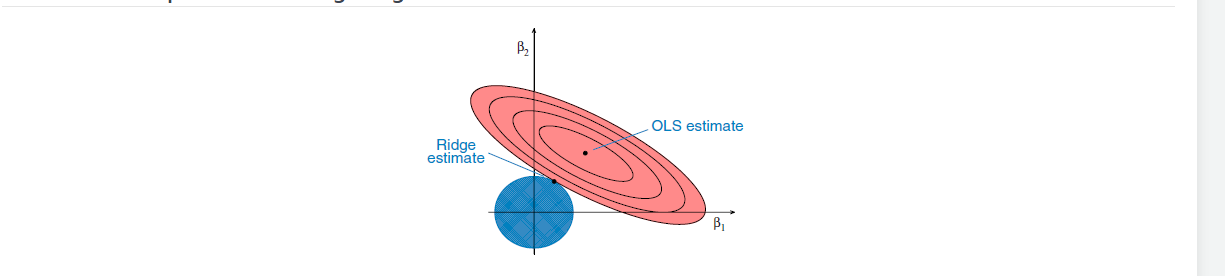

We are trying to minimize the ellipse size and circle simultaneously in the ridge regression. The ridge estimate is given by the point at which the ellipse and the circle touch.
Components tend to zero

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

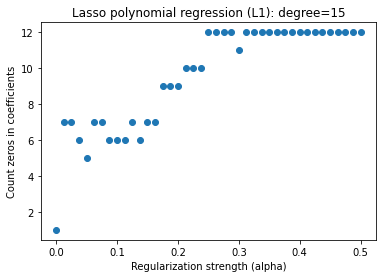

In [ ]:
avg_coef_matrix, avg_coef = [], []
for alpha in ALPHAS:
  results = cross_validate(make_model(degree = 15, penalty = 'L1', alpha=alpha),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
  avg_coef_matrix.append(        
        # average over CV folds
        np.array([            
            # mean absolute value of weights
            np.array(np.abs(model['reg'].coef_))
            
            for model in results['estimator']
        ]))
for matrix in avg_coef_matrix:
  avg_coef.append(
      [
                np.mean(matrix[:, i])
                for i in range(len(matrix[0]))
      ]
  )
#print(avg_coef_matrix)
zero_count= [avg_coef[i].count(0) for i in range(len(avg_coef))]
plt.scatter(ALPHAS, zero_count)
plt.title('Lasso polynomial regression (L1): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Count zeros in coefficients')
plt.show()

#### L2

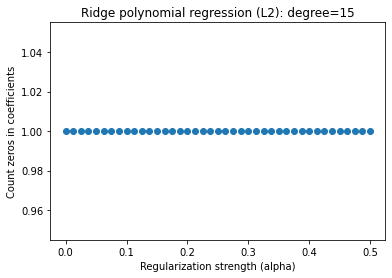

In [ ]:
avg_coef_matrix, avg_coef = [], []
for alpha in ALPHAS:
  results = cross_validate(make_model(degree = 15, penalty = 'L2', alpha=alpha),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
  avg_coef_matrix.append(        
        # average over CV folds
        np.array([            
            # mean absolute value of weights
            np.array(np.abs(model['reg'].coef_))
            
            for model in results['estimator']
        ]))
for matrix in avg_coef_matrix:
  avg_coef.append(
      [
                np.mean(matrix[:, i])
                for i in range(len(matrix[0]))
      ]
  )
#print(avg_coef_matrix)
zero_count= [avg_coef[i].count(0) for i in range(len(avg_coef))]
plt.scatter(ALPHAS, zero_count)
plt.title('Ridge polynomial regression (L2): degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Count zeros in coefficients')
plt.show()

#### Summary


##### Lasso 
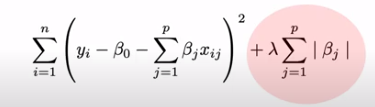

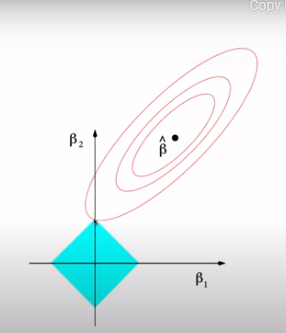

The lasso performs  shrinkage so that there are "corners'' in the constraint, which in two dimensions corresponds to a diamond. If the sum of squares "hits'' one of these corners, then the coefficient corresponding to the axis is shrunk to zero.

Therefore, some components are equal to zero

##### Ridge

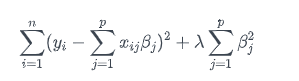

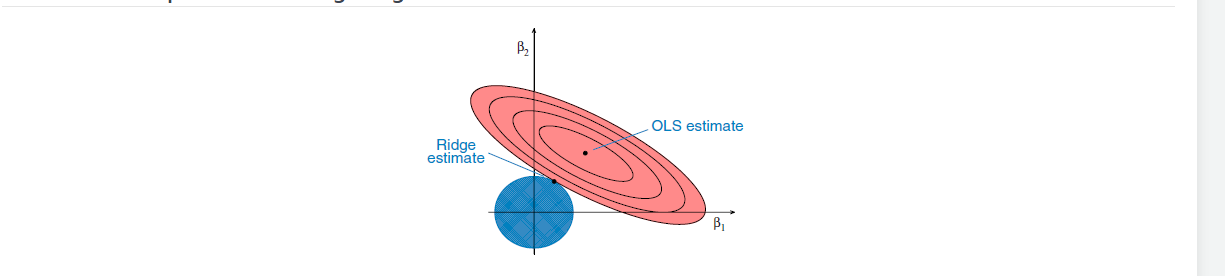

We are trying to minimize the ellipse size and circle simultaneously in the ridge regression. The ridge estimate is given by the point at which the ellipse and the circle touch.
Components tend to zero

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

Если у нас есть огромные "дырки" в данных, то модель будет думать, что большие числа обладают некоторым преимуществом и результат модели будет неверный.
Некоторые типы алгоритмов очень чувствительный к диапазону данных, что может вызвать ошибки в прогнозе.
Если у нас очень большой диапазон данных, это может вызвать дополнительные проблемы:
Долгое обучение
Больше памяти
Если будем увеличивать производительность в железе, это будет куда более затратно, чем просто стандартизировать данные

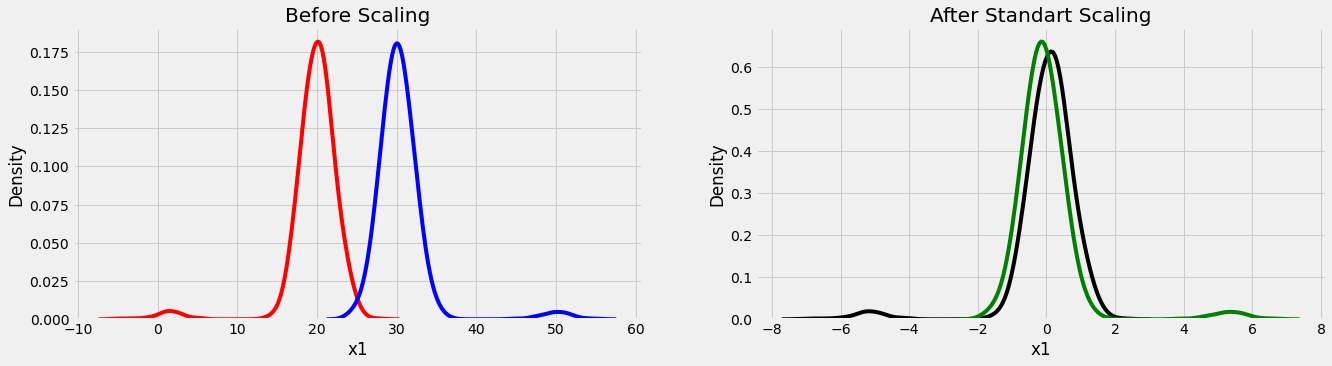

In [ ]:
import pandas as pd 
import numpy as np 
from sklearn import preprocessing 
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns  
matplotlib.style.use('fivethirtyeight') 
  
# data 
x = pd.DataFrame({ 
    # Distribution with lower outliers 
    'x1': np.concatenate([np.random.normal(20, 2, 1000), np.random.normal(1, 2, 25)]), 
    # Distribution with higher outliers 
    'x2': np.concatenate([np.random.normal(30, 2, 1000), np.random.normal(50, 2, 25)]), 
}) 
np.random.normal 
  

  
scaler = preprocessing.StandardScaler() 
standard_df = scaler.fit_transform(x) 
standard_df = pd.DataFrame(standard_df, columns =['x1', 'x2']) 
  

  
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(20, 5)) 
ax1.set_title('Before Scaling') 
  
sns.kdeplot(x['x1'], ax = ax1, color ='r') 
sns.kdeplot(x['x2'], ax = ax1, color ='b') 

  

  
sns.kdeplot(standard_df['x1'], ax = ax2, color ='black') 
sns.kdeplot(standard_df['x2'], ax = ax2, color ='g') 
ax2.set_title('After Standart Scaling') 
  

plt.show() 

Что видно из скриншота?
Данные сместились ближе к одному центру и уменьшился их диапазон.